In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=423a309924b099740801a7e6373cd153f693085dcda0473c118276fe98a6763e
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [2]:
# This for Google Colab, so that we can import the files from the repository
!git clone https://github.com/algolab-quantique/IMACA-CMAI-Grover.git

import sys

sys.path.insert(0,'/content/IMACA-CMAI-Grover')

Cloning into 'IMACA-CMAI-Grover'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 22 (delta 9), reused 17 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 7.72 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (9/9), done.


# Import necessary utils

In [115]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate, ZGate

import os, sys
sys.path.append(os.getcwd())

from utils import get_disjunction_control_state, get_disjunction_qubits

# Write the seven statements of the Pincus problem

A clause of the form

$
    (x_0 \lor x_2 \lor \neg x_3)
$

is written :
```
clause = {'x0' : True, 'x2' : True, 'x3' : False}
````

Remember :

* x0 = Fearful
* x1 = Happy
* x2 = Unhealthy
* x3 = Noisy


In [135]:
clauses = []
'''
# If a native is healthy and courageous, he is also noisy
# (x2 ⌵  x0 ⌵ x3 )
clauses.append({'d' : False, 'f' : False})

# If a native is quiet and fearful, he is also happy
# (¬x0 ⌵ x3 ⌵ x1)
# write the definition of the clause here
clauses.append({'o' : True, 'o' : True})

# If a native is healthy and noisy, he is also happy
# (x2 ⌵ ¬x3 ⌵ x1)
# write the definition of the clause here
clauses.append({'l' : False, 'c' : False})

# If a native is happy and quite, he is also healthy
# (¬x1 ⌵ x3 ⌵ ¬x2)
# write the definition of the clause here
clauses.append({'c' : False, 'o' : False})


# If a native is fearful and healthy, he is also sad
# (¬x0 ⌵ x2 ⌵ ¬x1)
# write the definition of the clause here
clauses.append({'d' : False, 'f' : False})


'''
clauses = [
    {'x0': False, 'x3': False}, # (¬d ∨ ¬f)
    {'x4': True},               # (o)
    {'x2': False, 'x1': False}, # (¬l ∨ ¬c)
    {'x1': False, 'x4': False}, # (¬c ∨ ¬o)
    {'x2': False, 'x3': True}   # (¬l ∨ f)
]

# Setup known data of the problem

In [136]:
# x0 : fearful, x1 : happy, x2 : unhealthy, x3 : noisy
nb_variables = 5
# 7 statements
nb_clauses = len(clauses)

# Create function to transform disjunction statement into gate

Take a disjunction statement and transform it into quantum circuit.

For example, the statement :

$
    (x_0 \lor x_1 \lor \neg x_2)
$

would result in the following gates :

<img src="https://github.com/algolab-quantique/IMACA-CMAI-Grover/blob/main/disj_circuit.png?raw=1" alt= “” width="15%" height="15%">

Each disjunction is transformed into a circuit containing as many qubits as there is variables in the statement,
with one ancillar qubit. The circuit is then converted to a gate that can be appended to the main grover circuit,
by specifying the right control and ancillar qubits.

In [137]:
# Tranform logical disjunction into Quantum Gate
def logical_disjunction_to_gate(disj_clause):
    # Get the number of variables included in the disjuntion clause
    nb_disj_variables = len(disj_clause)

    # Set the number of qubits as the number of variables in disjunction + 1 ancillar qubit
    nb_qubits = nb_disj_variables + 1
    disj_qc = QuantumCircuit(nb_qubits)
    qubits = disj_qc.qubits

    # Get the right control state
    ctrl_state = get_disjunction_control_state(disj_clause)

    # Add an X gate to the ancillar qubit (the last qubit. Position -1 gives the last element)
    disj_qc.x(qubits[-1])

    # Create a multi-controlled X gate with specified control state. It has as many control
    # qubits as there are variables in the disjunction.
    mc_xgate = XGate().control(num_ctrl_qubits=nb_disj_variables, ctrl_state = ctrl_state)
    disj_qc.append(mc_xgate, qubits)

    # Transform the disjunction circuit into a gate to append to the grover circuit
    disj_gate = disj_qc.to_gate(label='mcx')

    return disj_gate

Let's see how this function works.

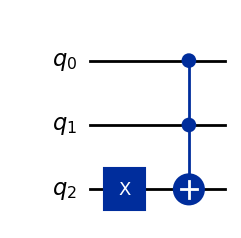

In [132]:
clause_test = {'d' : False, 'f' : False}


test_qc = QuantumCircuit(3)
disj_gate = logical_disjunction_to_gate(clause_test)
test_qc.append(disj_gate,range(3))
test_qc.decompose().draw('mpl')

# Construct the Oracle

In [138]:
# Create Quantum Registers for the variables and the clauses
var_qubits = QuantumRegister(nb_variables, name='x')
clause_qubits = QuantumRegister(nb_clauses, name='c')

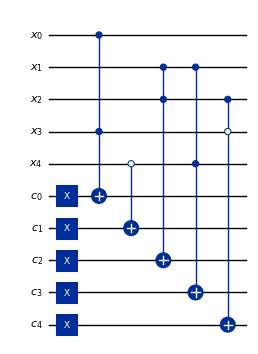

In [139]:
# Setup the clause circuit
clauses_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Add each clause as a disjunction gate :

# Clause 0
'''
# Convert the first clause into a quantum gate
gate = logical_disjunction_to_gate(clauses[0])
# Get the qubits associated with the first clause, including the variables involved in the clause.
c_qubits = get_disjunction_qubits(clauses[0], clause_qubits[0], var_qubits)
# Append the gate to the oracle circuit using the right qubits
clauses_circuit.append(gate, c_qubits)
'''
# Clause 1
for i in range( len(clauses)):#len calauses # or for clause , claause quibits in zip(clauses, clause_qubits) (allows to remove [i])
  # Write your code to append a gate associated to the second clause here #
  gate = logical_disjunction_to_gate(clauses[i])
  # Get the qubits associated with the first clause, including the variables involved in the clause.
  c_qubits = get_disjunction_qubits(clauses[i], clause_qubits[i], var_qubits)
  # Append the gate to the oracle circuit using the right qubits
  clauses_circuit.append(gate, c_qubits)

# Clause 2
# Write your code to append a gate associated to the clause here #

# ...

# Clause 6
# Write your code to append a gate associated to the clause here #


# P.S : you can use for loops if you want.

# Show the circuit :
clauses_circuit.decompose(gates_to_decompose=['mcx'], reps=1).draw(output='mpl', scale=0.5)# rep affect how comlicated cercuit

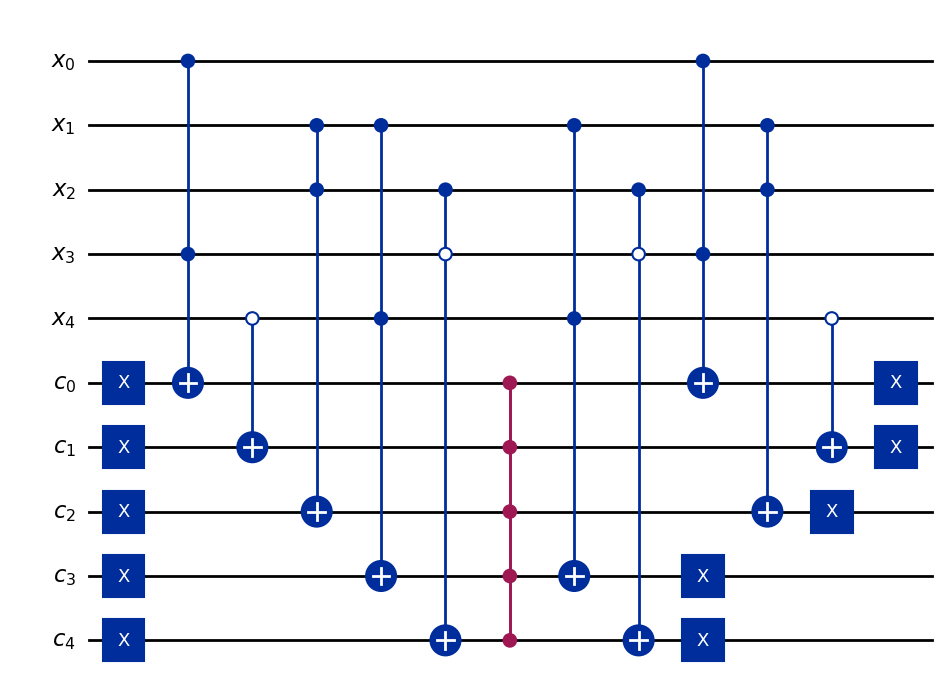

In [140]:
# Setup the oracle circuit
oracle_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Add clauses circuit
# --- transform to gate to use label (only for drawing purposes) ---
oracle_circuit.append(clauses_circuit.to_gate(label='clauses_circuit'), clauses_circuit.qubits)

# Add multi-control Z gate
mc_z_gate = ZGate().control(nb_clauses - 1)
oracle_circuit.append(mc_z_gate, clause_qubits)

# Add reversed clauses_circuit
oracle_circuit.append(clauses_circuit.reverse_ops().to_gate(label='clauses_circuit'), oracle_circuit.qubits)

# Show circuit
oracle_circuit.decompose(gates_to_decompose=['clauses_circuit', 'mcx'], reps=2).draw(output='mpl')


# Construct the diffuser

Complete the diffuser circuit.

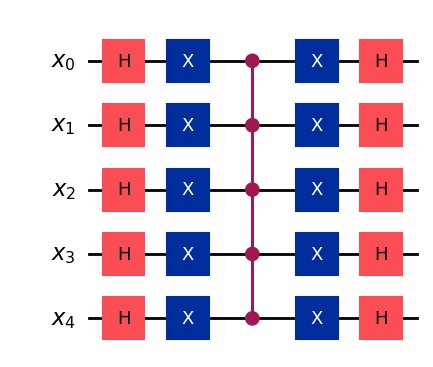

In [141]:
# Setup the grover circuit
diffuser_circuit = QuantumCircuit(var_qubits)

# Add H and X gates (change of basis)
diffuser_circuit.h(var_qubits)
diffuser_circuit.x(var_qubits)

# Add multi-control Z gate
mc_z_gate = ZGate().control(nb_variables - 1)
diffuser_circuit.append(mc_z_gate, var_qubits)

# Add X and H gates (revert change of basis)
diffuser_circuit.x(var_qubits)
diffuser_circuit.h(var_qubits)

# Show circuit
diffuser_circuit.draw(output='mpl')

# Assemble Grover circuit

Complete theGrover circuit.

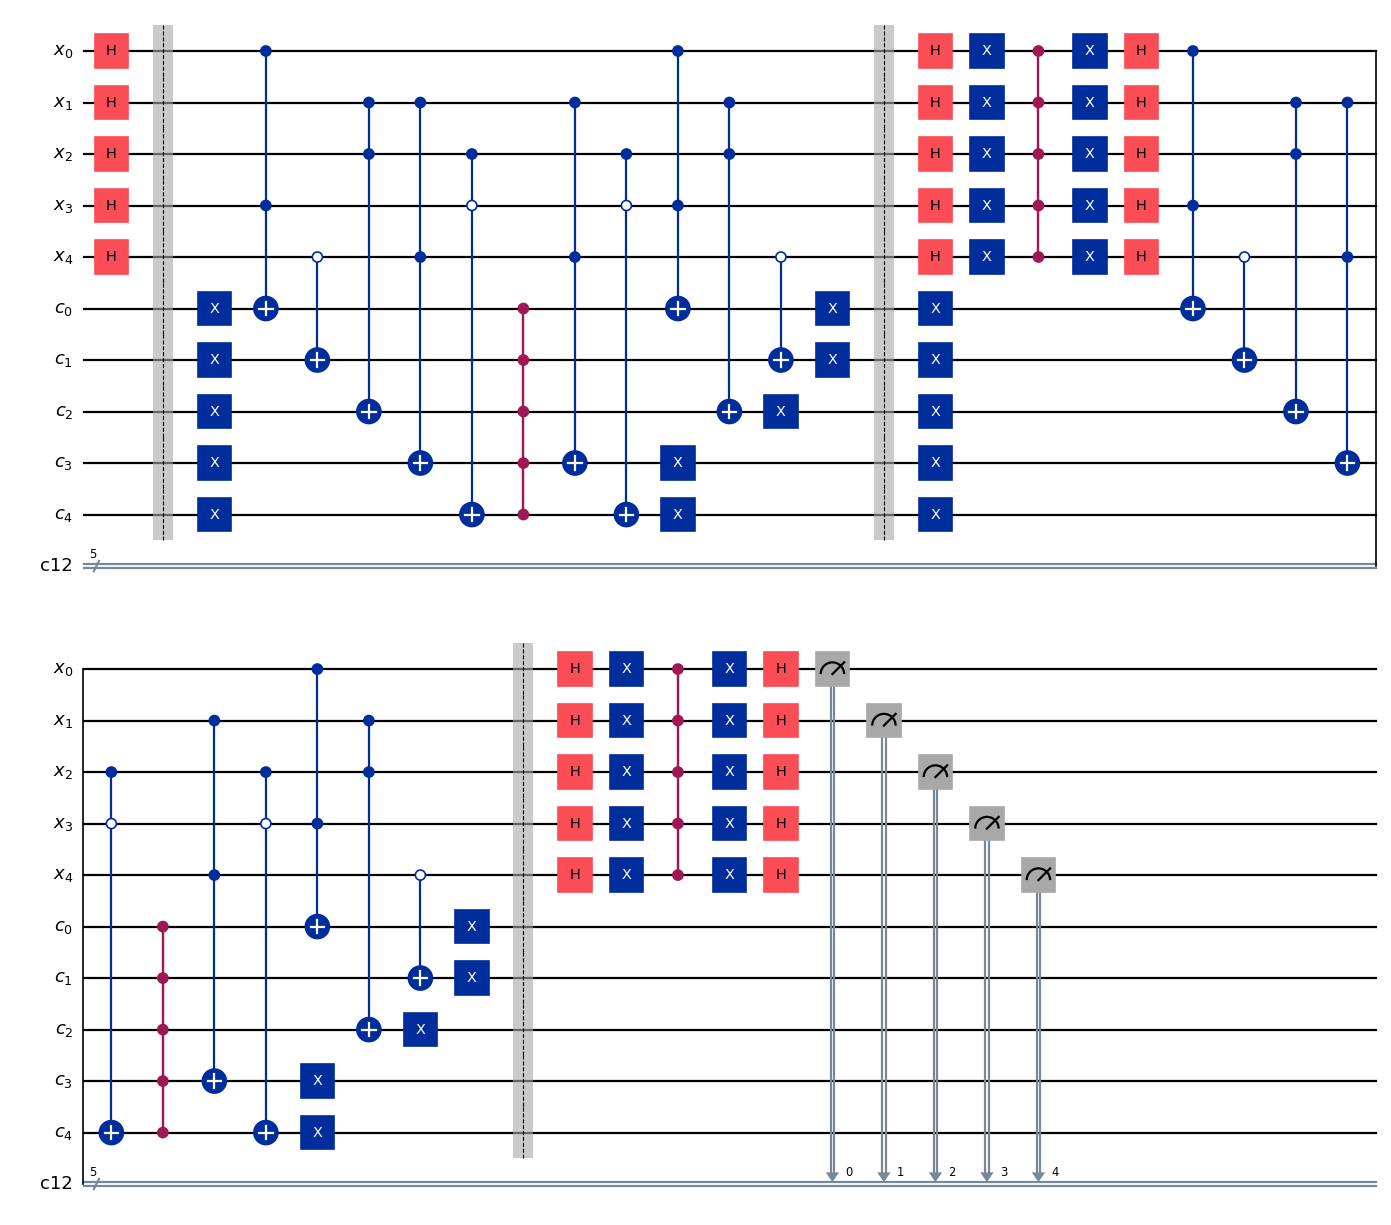

In [146]:
# Setup the Grover circuit
c_bits = ClassicalRegister(nb_variables)
grover_circuit = QuantumCircuit(var_qubits, clause_qubits, c_bits)

# Apply a H gate for all variables qubits
### Add 4 H gates on the right qubits (variables qubits)
grover_circuit.h(var_qubits)
grover_circuit.barrier(grover_circuit.qubits) # help keep things tidy

# Setup the number of iterations
nb_iterations = 2 # Play with the number of iterations

# Add as many oracle and diffusor circuits as there are iterations
for it in range(nb_iterations):
    grover_circuit.append(oracle_circuit.to_gate(label='oracle'), grover_circuit.qubits)
    grover_circuit.barrier(grover_circuit.qubits)
    #grover_circuit.append(diffuser_circuit.to_gate(label='diffusor'), grover_circuit.qubits[0:nb_variables])
    grover_circuit.append(diffuser_circuit.to_gate(label='diffusor'), var_qubits)

# Add measurement to evaluate the circuit
grover_circuit.measure(var_qubits, c_bits)

# Show circuit
grover_circuit.decompose(gates_to_decompose=['oracle', 'clauses_circuit', 'diffusor', 'mcx'], reps=3).draw(output='mpl',
                                                                                                   scale=0.8)

# Measure solution

In [147]:
# Prepare a simulation to run and measure the solution
def run_circuit(circ: QuantumCircuit) -> dict:
    """
    Run a quantum circuit on the AerSimulator and return the counts
    @param circ: QuantumCircuit to run
    @return: dictionary of measurement results and their counts
    """
    simulator = AerSimulator()
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=1024).result()
    return result.get_counts(circ)

In [148]:
# Execute circuit and get counts
counts = run_circuit(grover_circuit)
print(counts)

{'01000': 1, '11001': 2, '01011': 2, '00011': 2, '00111': 1, '10011': 1, '00000': 1, '10110': 2, '01110': 1, '11110': 2, '00100': 2, '11111': 4, '11000': 265, '01111': 2, '10000': 226, '11011': 3, '11101': 3, '10100': 1, '00001': 1, '10010': 2, '11100': 227, '10101': 2, '10111': 3, '01001': 2, '00101': 1, '10001': 260, '11010': 1, '01101': 3, '01100': 1}


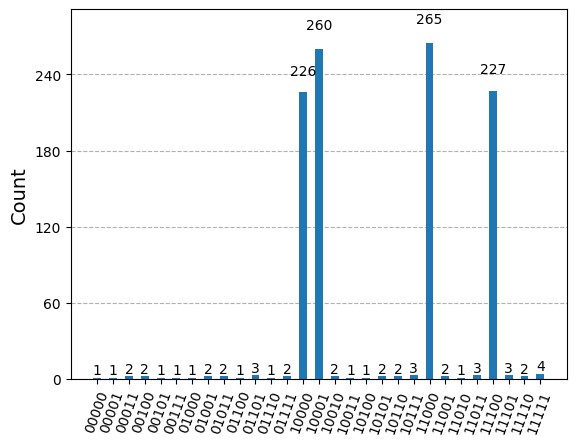

In [149]:
plot_histogram(counts)

Remember :

* x0 = Fearful
* x1 = Happy
* x2 = Unhealthy
* x3 = Noisy
